In [21]:
import torch
device = torch.device("cuda")
torch.cuda.current_device()
torch.cuda.get_device_name(torch.cuda.current_device())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [43]:
data = pd.read_csv('.\\Ha_Tinh_My_Loc\\Meteo_Vrain_data.csv')

In [44]:
Meteo = data[['Meteo']].values.reshape(-1, 1)
Vrain = data[['Vrain']].values.reshape(-1, 1)

In [45]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(Meteo)
y_scaled = scaler_y.fit_transform(Vrain)

sequence_length = 1
X, y = [], []

for i in range(len(X_scaled) - sequence_length):
    X.append(X_scaled[i:i + sequence_length])
    y.append(y_scaled[i + sequence_length])

X = np.array(X)
y = np.array(y)    

In [46]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [47]:
class RainConversionModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=1):
        super(RainConversionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_output = lstm_out[:, -1, :]
        return self.fc(last_time_step_output)   

In [48]:
def train_model(X_train, y_train, epochs, learning_rate):
    # Init
    model = RainConversionModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Convert to tensor
    # X_train_tensor = torch.FloatTensor(X_train)
    # y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    # Train
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        if epoch % 1 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model

In [49]:
trained_model = train_model(X_train, y_train, epochs=10, learning_rate=0.001)

Epoch 0, Loss: 0.000951595779042691
Epoch 1, Loss: 0.0009648778941482306
Epoch 2, Loss: 0.0009486815542913973
Epoch 3, Loss: 0.0009426268516108394
Epoch 4, Loss: 0.0009510113741271198
Epoch 5, Loss: 0.0009491423843428493
Epoch 6, Loss: 0.0009417211404070258
Epoch 7, Loss: 0.0009405809105373919
Epoch 8, Loss: 0.0009444606257602572
Epoch 9, Loss: 0.0009446793701499701


In [50]:
trained_model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
with torch.no_grad():
    predictions = trained_model(X_test_tensor)

y_pred_inv = scaler_X.inverse_transform(predictions.numpy())
y_test_inv = scaler_y.inverse_transform(y_test)

In [116]:
y_test_flat = y_test.flatten()
predictions_flat = predictions.flatten()

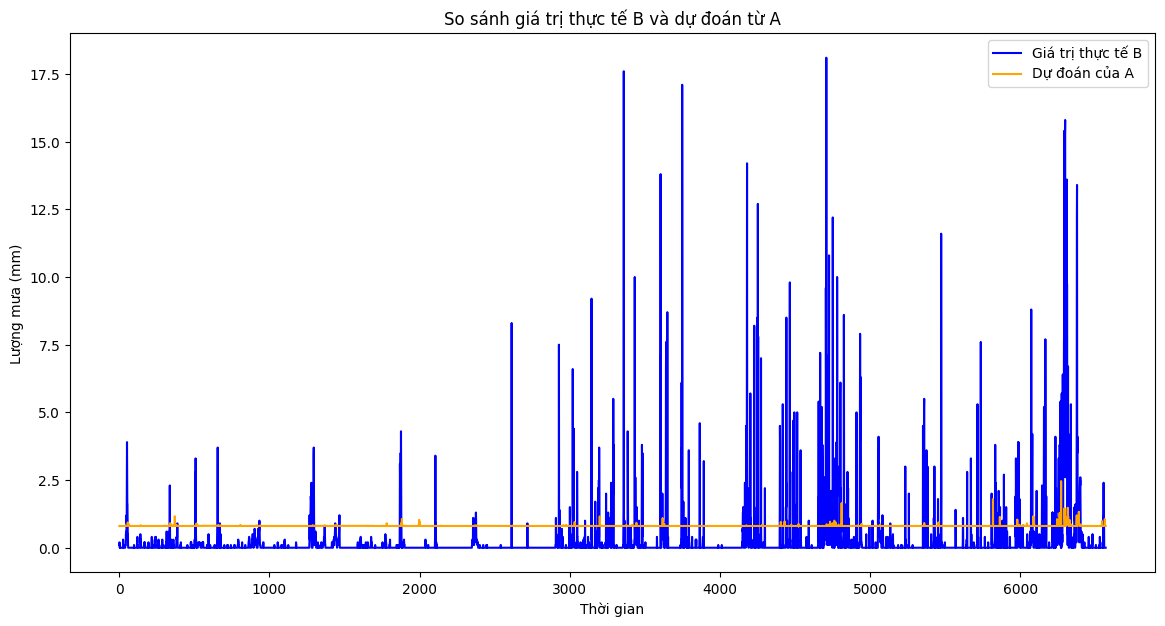

In [51]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Giá trị thực tế B', color='blue')
plt.plot(y_pred_inv, label='Dự đoán của A', color='orange')
plt.title('So sánh giá trị thực tế B và dự đoán từ A')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa (mm)')
plt.legend()
plt.show()

In [ ]:
# Lưu dự đoán vào file CSV
predictions = pd.DataFrame({'Actual B': y_test_inv.flatten(), 'Predicted A': y_pred_inv.flatten()})
predictions.to_csv('predictions.csv', index=False)